<a href="https://colab.research.google.com/github/HallelWeinberg/Image-Processing/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spatial Operations**
In this homework we will implement routines that perform spatial operations and use them to denoise images.


In [50]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import scipy
from scipy.signal import convolve2d

In [51]:
def add_SP_noise(im, p):
    sp_noise_im = im.copy()

    num_noisy_pixels = int(np.prod(im.shape) * p)

    height = random.sample(range(0, np.prod(im.shape) - 1), num_noisy_pixels)
    width = random.sample(range(0, np.prod(im.shape) - 1), num_noisy_pixels)

    # normalization:
    height = np.floor_divide(height, im.shape[0])
    width = np.floor_divide(width, im.shape[1])

    for i in range(int(num_noisy_pixels / 2)):
        sp_noise_im[height[i]][width[i]] = 0

    for i in range(int(num_noisy_pixels / 2), num_noisy_pixels):
        sp_noise_im[height[i]][width[i]] = 255

    return sp_noise_im


def clean_SP_noise_single(im, radius):
    noise_im = im.copy()
    clean_im = np.zeros((im.shape[0], im.shape[1]), dtype = np.float32)

    for i in range(im.shape[0]):
        for j in range(im.shape[1]):

            start_i = max(0, i - radius)
            end_i = min(im.shape[0], i + radius + 1)

            start_j = max(0, j - radius)
            end_j = min(im.shape[1], j + radius + 1)

            neighborhood = noise_im[start_i:end_i, start_j:end_j]

            clean_im[i][j] = np.median(neighborhood)

    return clean_im


def clean_SP_noise_multiple(images):
    clean_image = np.median(images, axis=0)
    return clean_image


def add_Gaussian_Noise(im, s):
    gaussian_noise_im = im.copy()

    noise = np.random.normal(0, s, im.shape)
    gaussian_noise_im = gaussian_noise_im + noise

    return gaussian_noise_im


def clean_Gaussian_noise(im, radius, maskSTD):
    # calculation of the filter:
    X, Y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
    gaussian_filter = np.power(np.e, np.negative(np.divide(np.square(X) + np.square(Y), 2 * np.square(maskSTD), dtype=np.float32)))

    # normalization:
    gaussian_filter = np.divide(gaussian_filter, np.sum(gaussian_filter))

    cleaned_im = scipy.signal.convolve2d(im, gaussian_filter, mode='same')

    return cleaned_im.astype(np.uint8)


def clean_Gaussian_noise_bilateral(im, radius, stdSpatial, stdIntensity):
    bilateral_im = im.copy()

    for i in range(im.shape[0]):
        for j in range(im.shape[1]):

            start_i = max(0, i - radius)
            end_i = min(bilateral_im.shape[0], i + radius + 1)

            start_j = max(0, j - radius)
            end_j = min(bilateral_im.shape[1], j + radius + 1)

            # edge cases:
            if start_i == 0:
                end_i = 1 + radius * 2
            if start_j == 0:
                end_j = 1 + radius * 2
            if end_i == bilateral_im.shape[0]:
                start_i = bilateral_im.shape[0] - 1 -2 * radius
            if end_j == bilateral_im.shape[1]:
                start_j = bilateral_im.shape[1] - 1 - 2 * radius

            X,Y = np.meshgrid(np.arange(start_i, end_i), np.arange(start_j, end_j))

            # calculation of window:
            window = bilateral_im[start_i:end_i, start_j:end_j]

            # calculation of gi & gs:
            gi = np.exp(np.negative(np.divide(np.square(bilateral_im[X,Y] - bilateral_im[i][j]), 2 * np.square(stdIntensity), dtype=np.float32)))
            gs = np.exp(np.negative(np.divide(np.square(X - i) + np.square(Y - j), 2 * np.square(stdSpatial), dtype=np.float32)))

            g = gi * gs

            # normalization:
            g = np.divide(g, np.sum(g))

            bilateral_im[i][j] = np.sum(g * window)

    return bilateral_im.astype(np.uint8)

In [52]:
if __name__ == '__main__':
    im = cv2.imread(r'lena.tif')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


    # Salt and pepper noise ----------------------------------------------------------------
    n = 50
    p = 0.3
    H, W = im.shape
    SP_images = np.zeros((n, H, W))
    # create n images with SP noise
    for i in range(n):
        SP_images[i, :, :] = add_SP_noise(im, p)

    clean_single_image = clean_SP_noise_single(SP_images[1, :, :], radius=1)
    # clean SP noise using images
    clean_multiple_images = clean_SP_noise_multiple(SP_images)

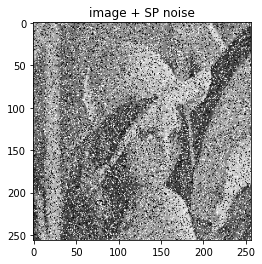

In [53]:
    plt.figure()
    plt.imshow(SP_images[1, :, :], cmap='gray', vmin=0, vmax=255)
    plt.title('image + SP noise')
    plt.show()

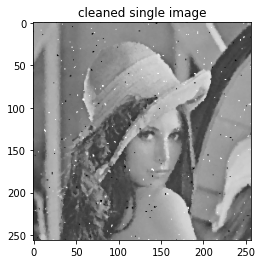

In [54]:
    plt.figure()
    plt.imshow(clean_single_image, cmap='gray', vmin=0, vmax=255)
    plt.title('cleaned single image')
    plt.show()

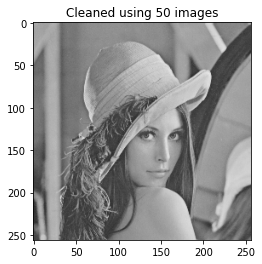

In [55]:
    plt.figure()
    plt.imshow(clean_multiple_images, cmap='gray', vmin=0, vmax=255)
    plt.title('Cleaned using {} images'.format(n))
    plt.show()

In [56]:
    # Gaussian noise ----------------------------------------------------------------
    STD=15
    gaussian_noised_im = add_Gaussian_Noise(im, s=STD)
    clean_im = clean_Gaussian_noise(gaussian_noised_im, 2, 5)
    # clean_bi_im = clean_Gaussian_noise_bilateral(gaussian_noised_im, 1, 5, 25)
    clean_bi_im = clean_Gaussian_noise_bilateral(gaussian_noised_im, 2, 5, 20)

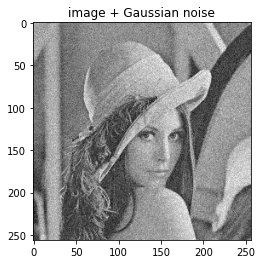

In [57]:
    plt.figure()
    plt.imshow(gaussian_noised_im, cmap='gray', vmin=0, vmax=255)
    plt.title('image + Gaussian noise')
    plt.show()

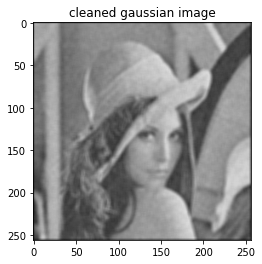

In [58]:
    plt.figure()
    plt.imshow(clean_im, cmap='gray', vmin=0, vmax=255)
    plt.title('cleaned gaussian image')
    plt.show()

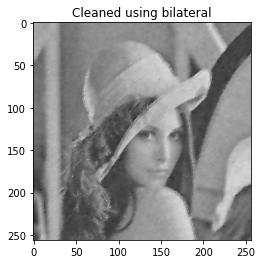

In [59]:
    plt.figure()
    plt.imshow(clean_bi_im, cmap='gray', vmin=0, vmax=255)
    plt.title('Cleaned using bilateral')
    plt.show()